## Import Packages

In [28]:
from utils import *
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, BatchNormalization, MaxPooling2D, Reshape, LSTM, TimeDistributed, Permute
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import CategoricalCrossentropy
import datetime

## Load Dataset

### load and preprocess data

In [48]:
X_train, y_train, X_test, y_test = init_data(subject=None, verbose=True)
X_train_aug, y_train_aug, X_test_aug, y_test_aug, X_valid_aug, y_valid_aug= preprocess_data(X_train, y_train, X_test, y_test, verbose=True, time_stamp=800)
X_train_aug, y_train_aug, X_valid_aug, y_valid_aug, X_test_aug, y_test_aug = load_data(X_train_aug, y_train_aug, X_valid_aug, y_valid_aug, X_test_aug, y_test_aug, verbose=True)

Training/Valid data shape: (2115, 22, 1000) Training/Valid target shape: (2115,)
Test data shape: (443, 22, 1000) Test target shape: (443,)
Person train/valid shape: (2115, 1) Person test shape: (443, 1)
Training data shape: (7616, 22, 400) Training target shape: (7616,)
Testing data shape: (443, 22, 400) Testing target shape: (443,)
Training data shape: (7616, 400, 1, 22) Training target shape: (7616, 4)
Validation data shape: (844, 400, 1, 22) Validation target shape: (844, 4)
Testing data shape: (443, 400, 1, 22) Testing target shape: (443, 4)


## CNN + LSTM

### set seed 

In [47]:
np.random.seed(75)
tf.random.set_seed(75)

In [49]:
# Model parameters
learning_rate = 0.001
dropout = 0.6
batch_size = 64
epochs = 100
hybrid_cnn_lstm_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, weight_decay=1e-4)

# Building the CNN model using sequential class
hybrid_cnn_lstm_model = Sequential()

# Conv. block 1
hybrid_cnn_lstm_model.add(Conv2D(filters=25, kernel_size=(15,1), padding='same', activation='elu', input_shape=(400,1,22)))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), strides=(3,1), padding='same')) # Read the keras documentation
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(dropout))

# Conv. block 2
hybrid_cnn_lstm_model.add(Conv2D(filters=50, kernel_size=(15,1), padding='same', activation='elu'))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), strides=(3,1), padding='same'))
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(dropout))

# Conv. block 3
hybrid_cnn_lstm_model.add(Conv2D(filters=100, kernel_size=(15,1), padding='same', activation='elu'))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), strides=(3,1), padding='same'))
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(dropout))

# FC+LSTM layers
hybrid_cnn_lstm_model.add(Flatten()) # Adding a flattening operation to the output of CNN block
hybrid_cnn_lstm_model.add(Dense((40))) # FC layer with 100 units
hybrid_cnn_lstm_model.add(Reshape((40,1))) # Reshape my output of FC layer so that it's compatible

hybrid_cnn_lstm_model.add(LSTM(10, dropout=dropout, recurrent_dropout=0.1))
# Output layer with Softmax activation 
hybrid_cnn_lstm_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


# Compiling the model
hybrid_cnn_lstm_model.compile(loss='categorical_crossentropy',
                 optimizer=hybrid_cnn_lstm_optimizer,
                 metrics=['accuracy'],
                )

hybrid_cnn_lstm_model.summary()



Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 400, 1, 25)        8275      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 134, 1, 25)       0         
 g2D)                                                            
                                                                 
 batch_normalization_18 (Bat  (None, 134, 1, 25)       100       
 chNormalization)                                                
                                                                 
 dropout_18 (Dropout)        (None, 134, 1, 25)        0         
                                                                 
 conv2d_19 (Conv2D)          (None, 134, 1, 50)        18800     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 45, 1, 50)       

### Training and validating the model


In [50]:
hybrid_cnn_lstm_model_results = hybrid_cnn_lstm_model.fit(X_train_aug,
             y_train_aug,
             batch_size=batch_size,
             epochs=epochs,
             validation_data=(X_valid_aug, y_valid_aug), verbose=True,
             )

Epoch 1/100
119/119 [==============================] - 7s 44ms/step - loss: 1.3771 - accuracy: 0.2736 - val_loss: 1.3572 - val_accuracy: 0.2950
Epoch 2/100
119/119 [==============================] - 5s 42ms/step - loss: 1.3260 - accuracy: 0.3416 - val_loss: 1.2998 - val_accuracy: 0.3483
Epoch 3/100
119/119 [==============================] - 5s 42ms/step - loss: 1.2743 - accuracy: 0.3894 - val_loss: 1.2358 - val_accuracy: 0.4182
Epoch 4/100
119/119 [==============================] - 5s 42ms/step - loss: 1.2348 - accuracy: 0.4221 - val_loss: 1.2140 - val_accuracy: 0.4313
Epoch 5/100
119/119 [==============================] - 5s 42ms/step - loss: 1.1969 - accuracy: 0.4529 - val_loss: 1.1700 - val_accuracy: 0.4526
Epoch 6/100
119/119 [==============================] - 5s 42ms/step - loss: 1.1634 - accuracy: 0.4727 - val_loss: 1.1664 - val_accuracy: 0.4727
Epoch 7/100
119/119 [==============================] - 5s 43ms/step - loss: 1.1394 - accuracy: 0.4829 - val_loss: 1.1696 - val_accuracy:

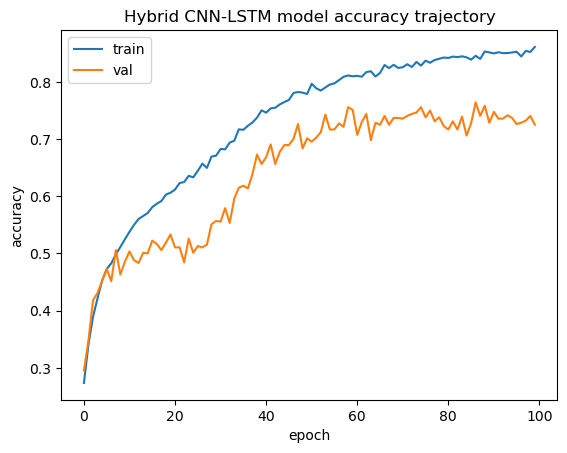

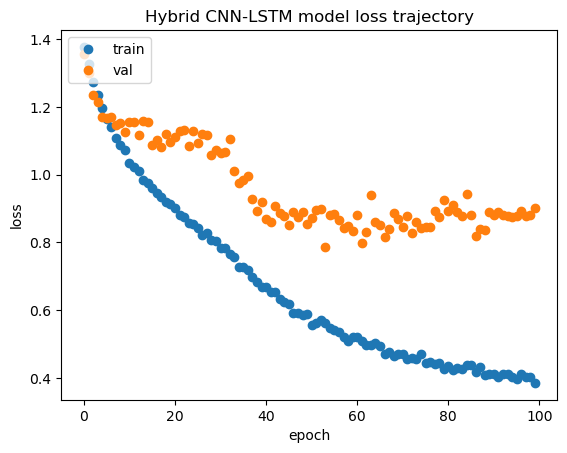

In [51]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(hybrid_cnn_lstm_model_results.history['accuracy'])
plt.plot(hybrid_cnn_lstm_model_results.history['val_accuracy'])
plt.title('Hybrid CNN-LSTM model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(hybrid_cnn_lstm_model_results.history['loss'],'o')
plt.plot(hybrid_cnn_lstm_model_results.history['val_loss'],'o')
plt.title('Hybrid CNN-LSTM model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train' , 'val'], loc='upper left')
plt.show()

### Test on all subjects

In [52]:
## Testing the hybrid CNN-LSTM model

hybrid_cnn_lstm_score = hybrid_cnn_lstm_model.evaluate(X_test_aug, y_test_aug, verbose=0)
print('Test accuracy of the hybrid CNN-LSTM model:',hybrid_cnn_lstm_score[1])

Test accuracy of the hybrid CNN-LSTM model: 0.7178329825401306


### Test on subject 1

In [53]:
X_train_subject, y_train_subject, X_test_subject, y_test_subject = init_data(subject=0, verbose=True)
X_train_aug_subject, y_train_aug_subject, X_test_aug_subject, y_test_aug_subject, X_valid_aug_subject, y_valid_aug_subject= preprocess_data(X_train_subject, y_train_subject, X_test_subject, y_test_subject, verbose=True, time_stamp=800)
_, _, _, _, X_test_aug_subject, y_test_aug_subject = load_data(X_train_aug_subject, y_train_aug_subject, X_valid_aug_subject, y_valid_aug_subject, X_test_aug_subject, y_test_aug_subject, verbose=True)

Training Subject 0: Training data shape: (237, 22, 1000) Testing data shape: (237,)
Testing Subject 0: Training data shape: (50, 22, 1000) Testing data shape: (50,)
Training data shape: (856, 22, 400) Training target shape: (856,)
Testing data shape: (50, 22, 400) Testing target shape: (50,)
Training data shape: (856, 400, 1, 22) Training target shape: (856, 4)
Validation data shape: (92, 400, 1, 22) Validation target shape: (92, 4)
Testing data shape: (50, 400, 1, 22) Testing target shape: (50, 4)


In [54]:
hybrid_cnn_lstm_score = hybrid_cnn_lstm_model.evaluate(X_test_aug_subject, y_test_aug_subject, verbose=0)
print('Test accuracy of the hybrid CNN-LSTM model on subject 0:',hybrid_cnn_lstm_score[1])

Test accuracy of the hybrid CNN-LSTM model on subject 0: 0.7200000286102295


## Trained based on time stamp

In [7]:
acc_timestamps = []

for j in range(200, 1001, 100):
    X_train, y_train, X_test, y_test = init_data(subject=None, verbose=False)
    X_train_aug, y_train_aug, X_test_aug, y_test_aug, X_valid_aug, y_valid_aug= preprocess_data(X_train, y_train, X_test, y_test, verbose=False, time_stamp=j)
    X_train_aug, y_train_aug, X_valid_aug, y_valid_aug, X_test_aug, y_test_aug = load_data(X_train_aug, y_train_aug, X_valid_aug, y_valid_aug, X_test_aug, y_test_aug, verbose=True)

    # Model parameters
    learning_rate = 0.001
    dropout = 0.6
    batch_size = 64
    epochs = 100
    hybrid_cnn_lstm_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, weight_decay=1e-4)

    # Building the CNN model using sequential class
    hybrid_cnn_lstm_model = Sequential()

    # Conv. block 1
    hybrid_cnn_lstm_model.add(Conv2D(filters=25, kernel_size=(15,1), padding='same', activation='elu', input_shape=(j//2,1,22)))
    hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), strides=(3,1), padding='same')) # Read the keras documentation
    hybrid_cnn_lstm_model.add(BatchNormalization())
    hybrid_cnn_lstm_model.add(Dropout(dropout))

    # Conv. block 2
    hybrid_cnn_lstm_model.add(Conv2D(filters=50, kernel_size=(15,1), padding='same', activation='elu'))
    hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), strides=(3,1), padding='same'))
    hybrid_cnn_lstm_model.add(BatchNormalization())
    hybrid_cnn_lstm_model.add(Dropout(dropout))

    # Conv. block 3
    hybrid_cnn_lstm_model.add(Conv2D(filters=100, kernel_size=(15,1), padding='same', activation='elu'))
    hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), strides=(3,1), padding='same'))
    hybrid_cnn_lstm_model.add(BatchNormalization())
    hybrid_cnn_lstm_model.add(Dropout(dropout))

    # FC+LSTM layers
    hybrid_cnn_lstm_model.add(Flatten()) # Adding a flattening operation to the output of CNN block
    hybrid_cnn_lstm_model.add(Dense((40))) # FC layer with 100 units
    hybrid_cnn_lstm_model.add(Reshape((40,1))) # Reshape my output of FC layer so that it's compatible

    hybrid_cnn_lstm_model.add(LSTM(10, dropout=dropout, recurrent_dropout=0.1))
    # Output layer with Softmax activation 
    hybrid_cnn_lstm_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


    # Compiling the model
    hybrid_cnn_lstm_model.compile(loss='categorical_crossentropy',
                    optimizer=hybrid_cnn_lstm_optimizer,
                    metrics=['accuracy'],
                    )

    hybrid_cnn_lstm_model_results = hybrid_cnn_lstm_model.fit(X_train_aug,
                y_train_aug,
                batch_size=batch_size,
                epochs=epochs,
                validation_data=(X_valid_aug, y_valid_aug), verbose=False,
                )
    
    score = hybrid_cnn_lstm_model.evaluate(X_test_aug, y_test_aug, verbose=0)
    print(f'Test accuracy for timestamp {j}: {score[1]}')
    acc_timestamps.append(score[1])



Training data shape: (7616, 100, 1, 22) Training target shape: (7616, 4)
Validation data shape: (844, 100, 1, 22) Validation target shape: (844, 4)
Testing data shape: (443, 100, 1, 22) Testing target shape: (443, 4)
Test accuracy for timestamp 200: 0.6546275615692139
Training data shape: (7616, 150, 1, 22) Training target shape: (7616, 4)
Validation data shape: (844, 150, 1, 22) Validation target shape: (844, 4)
Testing data shape: (443, 150, 1, 22) Testing target shape: (443, 4)
Test accuracy for timestamp 300: 0.6817155480384827
Training data shape: (7616, 200, 1, 22) Training target shape: (7616, 4)
Validation data shape: (844, 200, 1, 22) Validation target shape: (844, 4)
Testing data shape: (443, 200, 1, 22) Testing target shape: (443, 4)
Test accuracy for timestamp 400: 0.7042889595031738
Training data shape: (7616, 250, 1, 22) Training target shape: (7616, 4)
Validation data shape: (844, 250, 1, 22) Validation target shape: (844, 4)
Testing data shape: (443, 250, 1, 22) Testing

Text(0, 0.5, 'Accuracy')

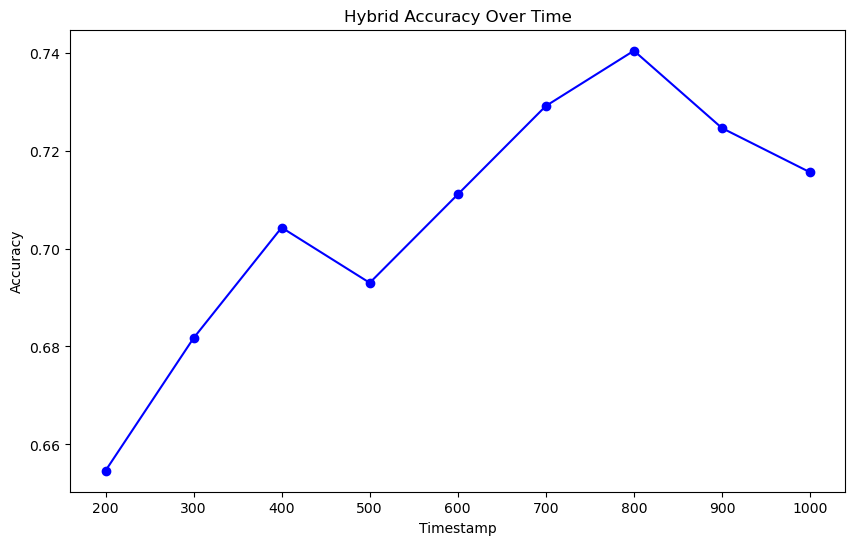

In [8]:
timestamps = [i for i in range(200, 1001, 100)]
plt.figure(figsize=(10, 6))
plt.plot(timestamps, acc_timestamps, marker='o', linestyle='-', color='b')

plt.title('Hybrid Accuracy Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Accuracy')

## Train based on Subjects

In [21]:
acc_subjects = []
acc_subject_v_all = []
X_train, y_train, X_test, y_test = init_data(subject=None, verbose=False)
X_train_aug, y_train_aug, X_test_aug, y_test_aug, X_valid_aug, y_valid_aug= preprocess_data(X_train, y_train, X_test, y_test, verbose=False, time_stamp=800)
_, _, _, _, X_test_aug_all, y_test_aug_all = load_data(X_train_aug, y_train_aug, X_valid_aug, y_valid_aug, X_test_aug, y_test_aug, verbose=False)

for i in range(9):
    X_train, y_train, X_test, y_test = init_data(subject=i, verbose=False)
    X_train_aug, y_train_aug, X_test_aug, y_test_aug, X_valid_aug, y_valid_aug= preprocess_data(X_train, y_train, X_test, y_test, verbose=False, time_stamp=800)
    X_train_aug, y_train_aug, X_valid_aug, y_valid_aug, X_test_aug, y_test_aug = load_data(X_train_aug, y_train_aug, X_valid_aug, y_valid_aug, X_test_aug, y_test_aug, verbose=False)

    # Model parameters
    learning_rate = 0.001
    dropout = 0.6
    batch_size = 64
    epochs = 100
    hybrid_cnn_lstm_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, weight_decay=1e-4)

    # Building the CNN model using sequential class
    hybrid_cnn_lstm_model = Sequential()

    # Conv. block 1
    hybrid_cnn_lstm_model.add(Conv2D(filters=25, kernel_size=(15,1), padding='same', activation='elu', input_shape=(400,1,22)))
    hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), strides=(3,1), padding='same')) # Read the keras documentation
    hybrid_cnn_lstm_model.add(BatchNormalization())
    hybrid_cnn_lstm_model.add(Dropout(dropout))

    # Conv. block 2
    hybrid_cnn_lstm_model.add(Conv2D(filters=50, kernel_size=(15,1), padding='same', activation='elu'))
    hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), strides=(3,1), padding='same'))
    hybrid_cnn_lstm_model.add(BatchNormalization())
    hybrid_cnn_lstm_model.add(Dropout(dropout))

    # Conv. block 3
    hybrid_cnn_lstm_model.add(Conv2D(filters=100, kernel_size=(15,1), padding='same', activation='elu'))
    hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), strides=(3,1), padding='same'))
    hybrid_cnn_lstm_model.add(BatchNormalization())
    hybrid_cnn_lstm_model.add(Dropout(dropout))

    # FC+LSTM layers
    hybrid_cnn_lstm_model.add(Flatten()) # Adding a flattening operation to the output of CNN block
    hybrid_cnn_lstm_model.add(Dense((40))) # FC layer with 100 units
    hybrid_cnn_lstm_model.add(Reshape((40,1))) # Reshape my output of FC layer so that it's compatible

    hybrid_cnn_lstm_model.add(LSTM(10, dropout=dropout, recurrent_dropout=0.1))
    # Output layer with Softmax activation 
    hybrid_cnn_lstm_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


    # Compiling the model
    hybrid_cnn_lstm_model.compile(loss='categorical_crossentropy',
                    optimizer=hybrid_cnn_lstm_optimizer,
                    metrics=['accuracy'],
                    )

    hybrid_cnn_lstm_model_results = hybrid_cnn_lstm_model.fit(X_train_aug,
                y_train_aug,
                batch_size=batch_size,
                epochs=epochs,
                validation_data=(X_valid_aug, y_valid_aug), verbose=False,
                )
    
    score = hybrid_cnn_lstm_model.evaluate(X_test_aug, y_test_aug, verbose=0)
    print(f'Test accuracy for subject {i}: {score[1]}')
    acc_subjects.append(score[1])

    score = hybrid_cnn_lstm_model.evaluate(X_test_aug_all, y_test_aug_all, verbose=0)
    print(f'Test accuracy for subject {i} to all data: {score[1]}')
    acc_subject_v_all.append(score[1])
   

print(acc_subjects)
print(acc_subject_v_all)

Test accuracy for subject 0: 0.6600000262260437
Test accuracy for subject 0 to all data: 0.3837471902370453
Test accuracy for subject 1: 0.5400000214576721
Test accuracy for subject 1 to all data: 0.3792324960231781
Test accuracy for subject 2: 0.5600000023841858
Test accuracy for subject 2 to all data: 0.3769751787185669
Test accuracy for subject 3: 0.46000000834465027
Test accuracy for subject 3 to all data: 0.3769751787185669
Test accuracy for subject 4: 0.6170212626457214
Test accuracy for subject 4 to all data: 0.4018058776855469
Test accuracy for subject 5: 0.4285714328289032
Test accuracy for subject 5 to all data: 0.2799097001552582
Test accuracy for subject 6: 0.6000000238418579
Test accuracy for subject 6 to all data: 0.45372459292411804
Test accuracy for subject 7: 0.4399999976158142
Test accuracy for subject 7 to all data: 0.32957109808921814
Test accuracy for subject 8: 0.7872340679168701
Test accuracy for subject 8 to all data: 0.32054176926612854
[0.6600000262260437, 0.5

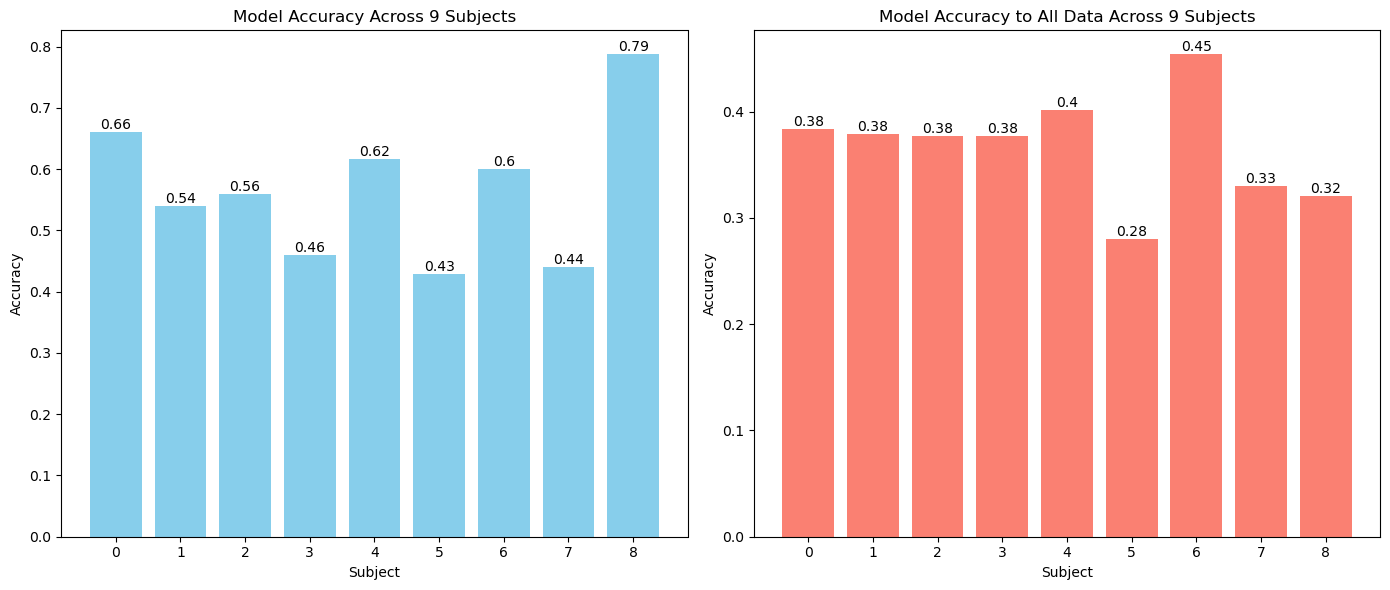

In [23]:
subjects = [i for i in range(9)]


plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1) 
bars = plt.bar(subjects, acc_subjects, color='skyblue')
plt.title('Model Accuracy Across 9 Subjects')
plt.xlabel('Subject')
plt.ylabel('Accuracy')
plt.xticks(subjects)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.subplot(1, 2, 2) 
bars = plt.bar(subjects, acc_subject_v_all, color='salmon')
plt.title('Model Accuracy to All Data Across 9 Subjects')
plt.xlabel('Subject')
plt.ylabel('Accuracy')
plt.xticks(subjects)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.tight_layout()
plt.show()